In [12]:
!pip install sounddevice
!pip install wavio

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import wavio
import sounddevice as sd
import sys

In [ ]:
# Since the majority of this is just small tweaks until things work, I've
# moved all of the tolerance and adjustment variables up here so they can
# be changed easily

# The window interval for our windowed fourier transform
# (requires that anaylze method 2 is used to have effect)
windowInterval = .02

noteTolerance = .75
noteToleranceWindowed = 1.0

volumeTolerance = 2.0 # This number times the background average

frequencyDeviationTolerance = 10.0 # Hz

In [48]:
def getData(recordDuration, sampleRate):
    recordData = sd.rec(int(recordDuration*sampleRate), samplerate=sampleRate, channels=2)
    sd.wait()
    
    adjustedData = recordData.flatten()
    
    #print(adjustedData)
    
    return adjustedData

In [56]:
# Method 1: Just use a basic fourier transform
def analyzeData(data, sampleRate, absoluteCutoff):
    fArr = abs(np.fft.fftfreq(len(data), 1.0 / sampleRate))
    fftArr = abs(np.fft.fft(data))**2
    
    #print(max(fftArr))
    
    #fftArr[np.where(fftArr**2 < absoluteCutoff)] = 0
        
    #print(fftArr)
    
    #plt.plot(fArr, np.real(fftArr))
    #plt.show()
    
    notes = identifyNotes(fArr, fftArr, tolerance=noteTolerance)
    
    # Print just a bunch of space to clear the previous typing
    sys.stdout.write("\r                                                                                ")
    sys.stdout.write("\rDetected Notes: " + str(notes))

In [10]:
# Method 2: Use a windowed fourier transform
def analyzeData(data, sampleRate):
    # And the sampling rate (aka inverse of the time interval)
    dt = 1 / sampleRate

    # Empty array that will store our notes
    notes = []
    
    # We want to take data on the notes every .25 seconds
    #windowInterval = .25 # This has been moved to an upper cell
    soundLength = (len(data) * dt)
    
    # Now we iterate over every section of the data
    for j in range(int(soundLength/windowInterval)):
        
        windowedData = data[int(len(data)*j/int(soundLength/windowInterval)):int(len(data)*(j+1)/int(soundLength/windowInterval))]
        
        #print(windowedData)
        
        # Now do the actual fourier transform and get the power spectrum
        fArr = abs(np.fft.fftfreq(len(windowedData), dt))
        fftArr = abs(np.fft.fft(windowedData))**3
        
        # We use the method identifyNotes to look at the maximums on the power spectrum
        notes = notes + identifyNotes(fArr, fftArr, tolerance=noteToleranceWindowed)
        
    #plt.plot(fArr, np.real(fftArr))
    #plt.show()
    
    # Print just a bunch of space to clear the previous typing
    sys.stdout.write("\r                                                                                ")
    sys.stdout.write("\rDetected Notes: " + str(notes))

In [ ]:
# This gives an estimate of the dominant frequencies in the sound
# file given the fourier transform
def identifyNotes(freq, data, tolerance = 1.0):
    
    # Open the file
    # Instead of manually typing each frequency note pair, I took the source code
    # for the following website and parse it below
    # https://www.seventhstring.com/resources/notefrequencies.html
    file = open("frequencies.txt")

    lines = file.read()
    #print(lines)

    # Here we are removing the html table formatting to just leave the data
    lines = lines.replace("tr", "")
    lines = lines.replace("td", "")
    lines = lines.replace("th", "")
    lines = lines.replace("<", "")
    lines = lines.replace(">", "")
    lines = lines.replace("\t", "")
    lines = lines.replace(" ", "")

    # Now split it into lines
    arr = lines.split("\n")  

    # And remove some blank lines
    while "" in arr:
        arr.remove("")

    # And remove all of the / lines too
    while "/" in arr:
        arr.remove("/")

    # Split the first line, since it contains the note headers
    notes = arr[0].split("/")    

    keys = []
    freqs = []
    for i in range(len(arr)-1):
        for j in range(1, len(notes)-1):
            keys.append(notes[j] + str(i))
            freqs.append(float(arr[i+1].split("/")[j]))

    # Create a dictionary with our frequencies and keys
    frequencies = dict(zip(freqs, keys))

    # Now search for frequencies who have a maximum that is comparable to the absolute maximum
    # Having a lower tolerance with mean more notes will be detected as being played
    fArr = freq[np.where(data > tolerance * max(data))]
    
    
    notes = []
    
    # Now look for notes by comparing the detected frequencies to the dictionary we created above
    # We say that if the frequency is within 10 Hz of the frequency for that note, it is being played
    # frequencyDeviationTolerance = 5.0 # Hz (This has been moved to an upper cell)
    for i in range(len(fArr)):
        for j in frequencies:
            if abs(fArr[i] - j) < frequencyDeviationTolerance:
                notes.append(frequencies[j])
                
    return np.unique(notes).tolist()

Taking background sample, please wait 5 seconds...


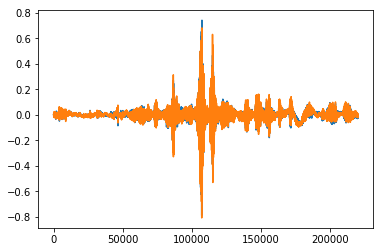

Background analysis complete!
Beginning sample acquisition...
Detected Notes: ['G#3']

KeyboardInterrupt: 

In [58]:
recordDuration = .5 # seconds
sampleRate = 44000 # samples/sec

# We want to take a background sample to remove any extra noise
backgroundDuration = 5

print("Taking background sample, please wait {} seconds...".format(backgroundDuration))
backgroundData = sd.rec(int(backgroundDuration*sampleRate), samplerate=sampleRate, channels=2)
sd.wait()

backgroundfftMax = np.real(max(abs(np.fft.fft(backgroundData.flatten()))))**2

#print(backgroundfftMax)

#backgroundAverage = np.mean(backgroundData.flatten())

plt.plot(backgroundData)
plt.show()

#print(backgroundAverage)

print("Background analysis complete!")
print("Beginning sample acquisition...")

while True:
    adjustedData = getData(recordDuration, sampleRate)
    
    # Since we want to filter based on volume, we can set a tolerance
    # I don't know what units this is in, I just messed around with it
    # until things looked good
    #volumeTolerance = .05 # This has been moved to an upper cell
    #if max(adjustedData) < backgroundAverage*volumeTolerance:
        #continue
    
    analyzeData(adjustedData, sampleRate, backgroundfftMax)

In [20]:
print(adjustedData)

[-9.6486445e-05 -9.5102565e-05 -8.2250655e-05 ... -1.1216191e-02
 -9.0169776e-03 -1.1364145e-02]


(0, 500)

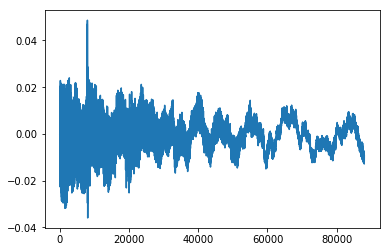

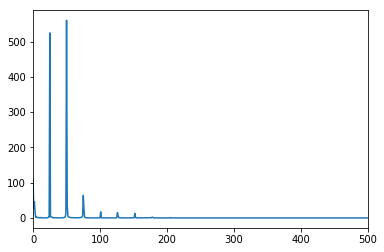

In [37]:
fig, ax = plt.subplots()
ax.plot(adjustedData)

FT = np.fft.fft(adjustedData[0:5000])
fig, ax =plt.subplots()
ax.plot(abs(FT)**2)
ax.set_xlim(0,500)